In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm_notebook as tqdm

In [3]:
with open("refined_profiles.pkl",'rb') as fp:
    df = pickle.load(fp)

df.head()

,Bios,Movies,Religion,Music,Politics,Social Media,Sports,Age
0,Typical twitter fanatic. Infuriatingly humble ...,"[Action, Adventure, Drama]",Catholic,"[Rock, Latin, HipHop]",Conservative,"[SnapChat, Facebook, Instagram]","[Football, Baseball, Hockey]",22
1,Web junkie. Analyst. Infuriatingly humble intr...,"[Action, Comedy, Drama]",Muslim,"[Latin, Country]",Liberal,"[Twitter, Facebook, Reddit]","[Football, Baseball]",19
2,Avid web maven. Food practitioner. Gamer. Twit...,"[Action, Adventure, Drama]",Christian,"[Rock, Country]",Conservative,"[LinkedIn, Facebook, Instagram]","[Football, Baseball]",21
3,Twitteraholic. Extreme web fanatic. Food buff....,"[Thriller, Adventure, Drama]",Hindu,"[Pop, Country]",Liberal,"[Youtube, Facebook, LinkedIn]","[Football, Baseball, Hockey]",24
4,Bacon enthusiast. Falls down a lot. Freelance ...,"[Horror, Adventure, Musical]",Muslim,"[Rock, HipHop]",Conservative,"[SnapChat, Youtube, Facebook]","[Football, Baseball]",19


In [4]:
def string_convert(x):
    if isinstance(x, list):
        return ' '.join(x)
    else:
        return x

for col in df.columns:
    df[col] = df[col].apply(string_convert)

In [5]:
df.head()

,Bios,Movies,Religion,Music,Politics,Social Media,Sports,Age
0,Typical twitter fanatic. Infuriatingly humble ...,Action Adventure Drama,Catholic,Rock Latin HipHop,Conservative,SnapChat Facebook Instagram,Football Baseball Hockey,22
1,Web junkie. Analyst. Infuriatingly humble intr...,Action Comedy Drama,Muslim,Latin Country,Liberal,Twitter Facebook Reddit,Football Baseball,19
2,Avid web maven. Food practitioner. Gamer. Twit...,Action Adventure Drama,Christian,Rock Country,Conservative,LinkedIn Facebook Instagram,Football Baseball,21
3,Twitteraholic. Extreme web fanatic. Food buff....,Thriller Adventure Drama,Hindu,Pop Country,Liberal,Youtube Facebook LinkedIn,Football Baseball Hockey,24
4,Bacon enthusiast. Falls down a lot. Freelance ...,Horror Adventure Musical,Muslim,Rock HipHop,Conservative,SnapChat Youtube Facebook,Football Baseball,19


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Bios          6600 non-null   object  
 1   Movies        6600 non-null   object  
 2   Religion      6600 non-null   category
 3   Music         6600 non-null   object  
 4   Politics      6600 non-null   category
 5   Social Media  6600 non-null   object  
 6   Sports        6600 non-null   object  
 7   Age           6600 non-null   int64   
dtypes: category(2), int64(1), object(5)
memory usage: 323.0+ KB


In [11]:
def vectorization(df, columns):
    column_name = columns[0]

    if column_name not in ['Bios', 'Movies','Religion', 'Music', 'Politics', 'Social Media', 'Sports']:
        return df

    if column_name in ['Religion', 'Politics']:
        df[column_name.lower()] = df[column_name].cat.codes

        df = df.drop(column_name, axis=1)

        return vectorization(df, df.columns)

    else:
        vectorizer = CountVectorizer()
        x = vectorizer.fit_transform(df[column_name])
        df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
        new_df = pd.concat([df, df_wrds], axis=1)
        new_df = new_df.drop(column_name, axis=1)
        return vectorization(new_df, new_df.columns)

In [12]:
vect_df = vectorization(df, df.columns)
scaler = MinMaxScaler()

vect_df = pd.DataFrame(scaler.fit_transform(vect_df), index=vect_df.index, columns=vect_df.columns)

In [13]:
vect_df.head()

,Age,advocate,aficionado,alcohol,alcoholaholic,amateur,analyst,animals,apathy,avid,...,snapchat,tiktok,twitter,youtube,baseball,basketball,football,hockey,other,soccer
0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0.035714,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.107143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.214286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [14]:
from sklearn.decomposition import PCA

pca = PCA()
df_pca = pca.fit_transform(vect_df)

total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_9 = len(total_explained_variance[total_explained_variance>=.99])
n_to_reach_9 = vect_df.shape[1] - n_over_9

print("PCA reduces the # of features from", vect_df.shape[1], 'to', n_to_reach_9)

pca = PCA(n_components=n_to_reach_9)

df_pca = pca.fit_transform(vect_df)

pca.explained_variance_ratio_.cumsum()[-1]

PCA reduces the # of features from 146 to 111


0.9898514008792142

In [15]:
cluster_cnt = [i for i in range(2, 11, 1)]

ch_scores = []

s_scores = []

db_scores = []

eval_df = df_pca

for i in tqdm(cluster_cnt):
    clust = AgglomerativeClustering(n_clusters=i, linkage='complete')
    clust.fit(eval_df)
    cluster_assignments = clust.labels_
    ch_scores.append(calinski_harabasz_score(eval_df, cluster_assignments))
    s_scores.append(silhouette_score(eval_df, cluster_assignments))
    db_scores.append(davies_bouldin_score(eval_df, cluster_assignments))

<ipython-input-15-2d390b7fac51>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(cluster_cnt):


  0%|          | 0/9 [00:00<?, ?it/s]

In [16]:
def cluster_eval(y, x):
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y

    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    plt.figure(figsize=(16,6))
    plt.style.use('bmh')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()

The Calinski-Harabasz Score (find max score):
Max Value:
Cluster #    Cluster Score
3      46.289526

Min Value:
Cluster #    Cluster Score
2      23.773063


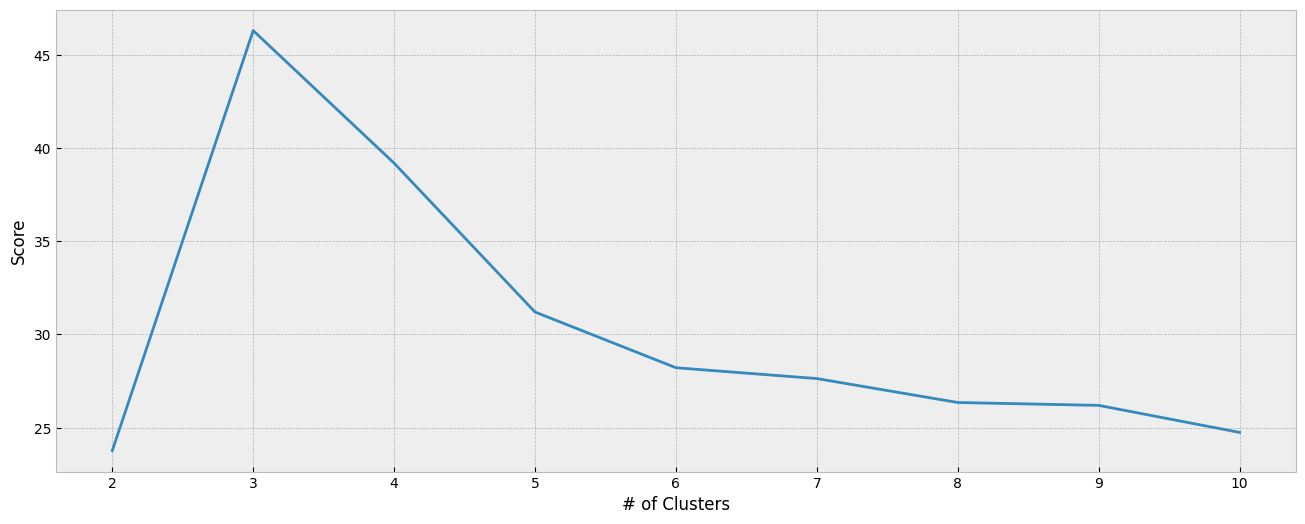


The Silhouette Coefficient Score (find max score):
Max Value:
Cluster #    Cluster Score
3       0.007726

Min Value:
Cluster #     Cluster Score
10       0.001305


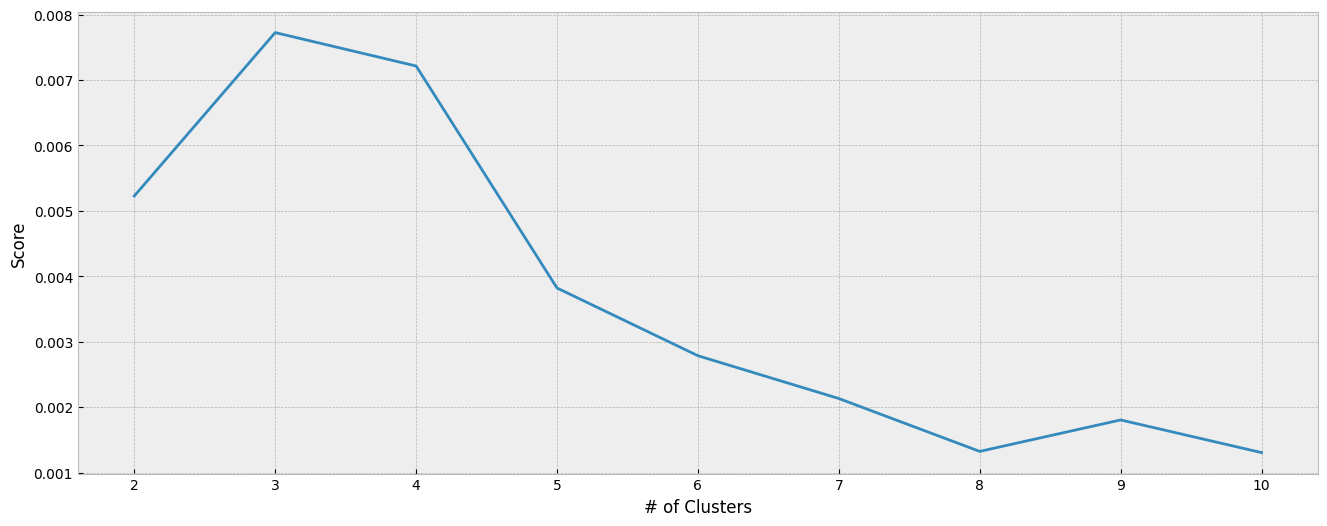


The Davies-Bouldin Score (find minimum score):
Max Value:
Cluster #    Cluster Score
2      16.057617

Min Value:
Cluster #    Cluster Score
4      10.275441


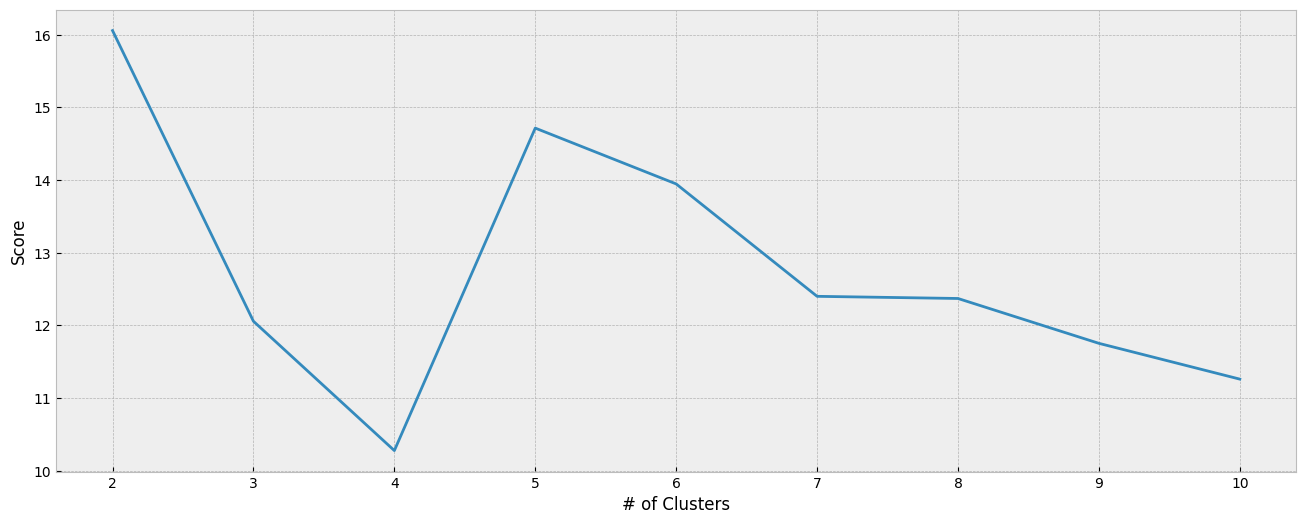

In [17]:
print("The Calinski-Harabasz Score (find max score):")
cluster_eval(ch_scores, cluster_cnt)

print("\nThe Silhouette Coefficient Score (find max score):")
cluster_eval(s_scores, cluster_cnt)

print("\nThe Davies-Bouldin Score (find minimum score):")
cluster_eval(db_scores, cluster_cnt)

In [18]:
hac = AgglomerativeClustering(n_clusters=3, linkage='complete')

hac.fit(df_pca)

cluster_assignments = hac.labels_

df['Cluster #'] = cluster_assignments

vect_df['Cluster #'] = cluster_assignments

In [19]:
with open("refined_cluster.pkl",'wb') as fp:
    pickle.dump(df, fp)

with open("vectorized_refined.pkl", 'wb') as fp:
    pickle.dump(vect_df, fp)

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [21]:
X = vect_df.drop(["Cluster #"], axis=1)
y = vect_df['Cluster #']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
dummy = DummyClassifier(strategy='stratified')

knn = KNeighborsClassifier()

svm = SVC(gamma='scale',max_iter=10000)

lr = LogisticRegression()

adab = AdaBoostClassifier()

models = [dummy, knn, svm, lr, adab]

names = ['Dummy', 'KNN', 'SVM', 'Logistic Regression', 'Adaboost']
classifiers = dict(zip(names, models))

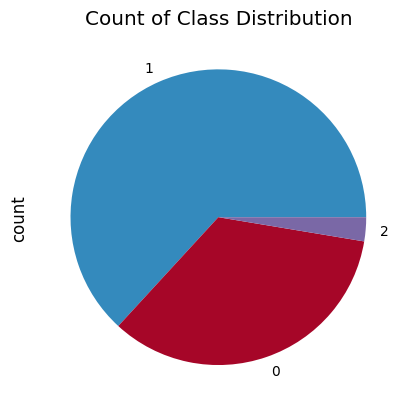

In [27]:
vect_df['Cluster #'].value_counts().plot(kind='pie', title='Count of Class Distribution');

In [28]:
models_f1 = {}

for name, model in tqdm(classifiers.items()):
    model.fit(X_train, y_train)
    print('\n'+ name + ' (Macro Avg - F1 Score):')
    report = classification_report(y_test, model.predict(X_test), output_dict=True)
    f1 = report['macro avg']['f1-score']
    models_f1[name] = f1

    print(f1)

<ipython-input-28-33509ee355e0>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for name, model in tqdm(classifiers.items()):


  0%|          | 0/5 [00:00<?, ?it/s]


Dummy (Macro Avg - F1 Score):
0.3226322306845717

KNN (Macro Avg - F1 Score):
0.8041037747464451

SVM (Macro Avg - F1 Score):
0.7929522621244162


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression (Macro Avg - F1 Score):
0.7880201317607155

Adaboost (Macro Avg - F1 Score):
0.6851948363912571


In [29]:
print(max(models_f1, key=models_f1.get), 'Score:', max(models_f1.values()))

KNN Score: 0.8041037747464451


In [30]:
knn.fit(X,y)

KNeighborsClassifier()

In [31]:
from joblib import dump

dump(knn, "knn_refined_model.joblib")

['knn_refined_model.joblib']